In [1]:
from gridworld import gameEnv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from collections import deque
import pickle
from skimage.color import rgb2gray
import random
import torch
import torch.nn as nn

<h3> Define Environment Object </h3>

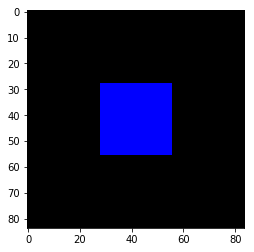

In [2]:
env = gameEnv(partial=True,size=9)

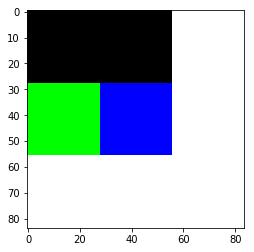

In [3]:
prev_state = env.reset()
plt.imshow(prev_state)

<h1 align='center'> Training Q Network </h1>

<h3> Hyper-parameters </h3>

In [4]:
BATCH_SIZE = 32
FREEZE_INTERVAL = 20000 # steps
MEMORY_SIZE = 60000 
OUTPUT_SIZE = 4
TOTAL_EPISODES = 10000
MAX_STEPS = 50
INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.1
GAMMA = 0.99
INPUT_IMAGE_DIM = 84
PERFORMANCE_SAVE_INTERVAL = 500 # episodes

<h3> Save Dictionay Function </h3>

In [5]:
def save_obj(obj, name ):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

<h3> Experience Replay </h3>

In [6]:
class Memory():
    
    def __init__(self,memsize):
        self.memsize = memsize
        self.memory = deque(maxlen=self.memsize)
    
    def add_sample(self,sample):
        self.memory.append(sample)
    
    def get_batch(self,size):
        return random.sample(self.memory,k=size)

<h3> Frame Collector </h3>

In [7]:
class FrameCollector():
    
    def __init__(self,num_frames,img_dim):
        self.num_frames = num_frames
        self.img_dim = img_dim
        self.frames = deque(maxlen=self.num_frames)
    
    def reset(self):
        tmp = np.zeros((self.img_dim,self.img_dim))
        for i in range(0,self.num_frames):
            self.frames.append(tmp)
    
    def add_frame(self,frame):
        self.frames.append(frame)
        
    def get_state(self):
        return np.array(self.frames)

<h3> Preprocess Images </h3>

In [8]:
def preprocess_image(image):
    image = rgb2gray(image) # this automatically scales the color for block between 0 - 1
    return np.copy(image)

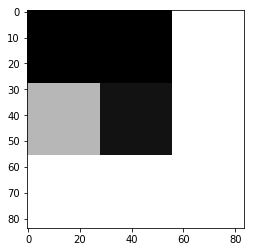

In [9]:
processed_prev_state = preprocess_image(prev_state)
plt.imshow(processed_prev_state,cmap='gray')

<h3> Build Model </h3>

In [10]:
import torch.nn as nn
import torch

class Network(nn.Module):
    
    def __init__(self,image_input_size,out_size):
        super(Network,self).__init__()
        self.image_input_size = image_input_size
        self.out_size = out_size

        self.conv_layer1 = nn.Conv2d(in_channels=4,out_channels=64,kernel_size=8,stride=4) # GRAY - 1
        self.conv_layer2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2)
        self.conv_layer3 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1)
        self.fc1 = nn.Linear(in_features=7*7*128,out_features=512)
        self.fc2 = nn.Linear(in_features=512,out_features=OUTPUT_SIZE)
        self.relu = nn.ReLU()

    def forward(self,x,bsize):
        x = x.view(bsize,4,self.image_input_size,self.image_input_size) # (N,Cin,H,W) batch size, input channel, height , width
        conv_out = self.conv_layer1(x)
        conv_out = self.relu(conv_out)
        conv_out = self.conv_layer2(conv_out)
        conv_out = self.relu(conv_out)
        conv_out = self.conv_layer3(conv_out)
        conv_out = self.relu(conv_out)
        out = self.fc1(conv_out.view(bsize,7*7*128))
        out = self.relu(out)
        out = self.fc2(out)
        return out

main_model = Network(image_input_size=INPUT_IMAGE_DIM,out_size=OUTPUT_SIZE).cuda()
print(main_model)

Network(
  (conv_layer1): Conv2d(4, 64, kernel_size=(8, 8), stride=(4, 4))
  (conv_layer2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (conv_layer3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
  (relu): ReLU()
)


<h3> Deep Q Learning with Freeze Network </h3>

In [ ]:
mem = Memory(memsize=MEMORY_SIZE)
main_model = Network(image_input_size=INPUT_IMAGE_DIM,out_size=OUTPUT_SIZE).float().cuda() # Primary Network
target_model = Network(image_input_size=INPUT_IMAGE_DIM,out_size=OUTPUT_SIZE).float().cuda() # Target Network
frameObj = FrameCollector(img_dim=INPUT_IMAGE_DIM,num_frames=4)

target_model.load_state_dict(main_model.state_dict())
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(main_model.parameters())

# filling memory with transitions
for i in range(0,int(MEMORY_SIZE/MAX_STEPS)):
    
    prev_state = env.reset()
    frameObj.reset()
    processed_prev_state = preprocess_image(prev_state)
    frameObj.add_frame(processed_prev_state)
    prev_frames = frameObj.get_state()
    step_count = 0
    game_over = False
    
    while (game_over == False) and (step_count < MAX_STEPS):
        
        step_count +=1
        action = np.random.randint(0,4)
        next_state,reward, game_over = env.step(action)
        processed_next_state = preprocess_image(next_state)
        frameObj.add_frame(processed_next_state)
        next_frames = frameObj.get_state()
        mem.add_sample((prev_frames,action,reward,next_frames,game_over))
    
        prev_state = next_state
        processed_prev_state = processed_next_state
        prev_frames = next_frames

print('Populated %d Samples in Episodes : %d'%(len(mem.memory),int(MEMORY_SIZE/MAX_STEPS)))


# Algorithm Starts
total_steps = 0
epsilon = INITIAL_EPSILON
loss_stat = []
total_reward_stat = []

for episode in range(0,TOTAL_EPISODES):
    
    prev_state = env.reset()
    frameObj.reset()
    processed_prev_state = preprocess_image(prev_state)
    frameObj.add_frame(processed_prev_state)
    prev_frames = frameObj.get_state()
    game_over = False
    step_count = 0
    total_reward = 0
    
    while (game_over == False) and (step_count < MAX_STEPS):
        
        step_count +=1
        total_steps +=1
        
        if np.random.rand() <= epsilon:
            action = np.random.randint(0,4)
        else:
            with torch.no_grad():
                torch_x = torch.from_numpy(prev_frames).float().cuda()

                model_out = main_model.forward(torch_x,bsize=1)
                action = int(torch.argmax(model_out.view(OUTPUT_SIZE),dim=0))
                
        next_state, reward, game_over = env.step(action)
        processed_next_state = preprocess_image(next_state)
        frameObj.add_frame(processed_next_state)
        next_frames = frameObj.get_state()
        total_reward += reward
        
        mem.add_sample((prev_frames,action,reward,next_frames,game_over))
        
        prev_state = next_state
        processed_prev_state = processed_next_state
        prev_frames = next_frames
        
        if (total_steps % FREEZE_INTERVAL) == 0:
            target_model.load_state_dict(main_model.state_dict())
        
        batch = mem.get_batch(size=BATCH_SIZE)
        current_states = []
        next_states = []
        acts = []
        rewards = []
        game_status = []
        
        for element in batch:
            current_states.append(element[0])
            acts.append(element[1])
            rewards.append(element[2])
            next_states.append(element[3])
            game_status.append(element[4])
            
        current_states = np.array(current_states)
        next_states =  np.array(next_states)
        rewards = np.array(rewards)
        game_status = [not b for b in game_status]
        game_status_bool = np.array(game_status,dtype='float') # FALSE 1, TRUE 0
        torch_acts = torch.tensor(acts)
        
        Q_next = target_model.forward(torch.from_numpy(next_states).float().cuda(),bsize=BATCH_SIZE)
        Q_s = main_model.forward(torch.from_numpy(current_states).float().cuda(),bsize=BATCH_SIZE)
        Q_max_next, _ = Q_next.detach().max(dim=1)
        Q_max_next = Q_max_next.double()
        Q_max_next = torch.from_numpy(game_status_bool).cuda()*Q_max_next
        
        target_values = (rewards + (GAMMA * Q_max_next))
        Q_s_a = Q_s.gather(dim=1,index=torch_acts.cuda().unsqueeze(dim=1)).squeeze(dim=1)
    
        loss = criterion(Q_s_a,target_values.float().cuda())
        
        # save performance measure
        loss_stat.append(loss.item())
        
        # make previous grad zero
        optimizer.zero_grad()
        
        # back - propogate 
        loss.backward()
        
        # update params
        optimizer.step()
    
    # save performance measure
    total_reward_stat.append(total_reward)
    
    if epsilon > FINAL_EPSILON:
        epsilon -= (INITIAL_EPSILON - FINAL_EPSILON)/TOTAL_EPISODES
    
    if (episode + 1)% PERFORMANCE_SAVE_INTERVAL == 0:
        perf = {}
        perf['loss'] = loss_stat
        perf['total_reward'] = total_reward_stat
        save_obj(name='FOUR_OBSERV_NINE',obj=perf)
    
    #print('Completed episode : ',episode+1,' Epsilon : ',epsilon,' Reward : ',total_reward,'Loss : ',loss.item(),'Steps : ',step_count)


Populated 60000 Samples in Episodes : 1200


<h3> Save Primary Network Weights </h3>

In [12]:
torch.save(main_model.state_dict(),'data/FOUR_OBSERV_NINE_WEIGHTS.torch')

<h1 align='center'> Testing Policy </h1>

<h3> Load Primary Network Weights </h3>

In [13]:
weights = torch.load('data/FOUR_OBSERV_NINE_WEIGHTS.torch')
main_model.load_state_dict(weights)

<h3> Testing Policy </h3>

In [ ]:
# Algorithm Starts
epsilon = INITIAL_EPSILON
FINAL_EPSILON = 0.01
total_reward_stat = []

for episode in range(0,TOTAL_EPISODES):
    
    prev_state = env.reset()
    processed_prev_state = preprocess_image(prev_state)
    frameObj.reset()
    frameObj.add_frame(processed_prev_state)
    prev_frames = frameObj.get_state()
    game_over = False
    step_count = 0
    total_reward = 0
    
    while (game_over == False) and (step_count < MAX_STEPS):
        
        step_count +=1
        
        if np.random.rand() <= epsilon:
            action = np.random.randint(0,4)
        else:
            with torch.no_grad():
                torch_x = torch.from_numpy(prev_frames).float().cuda()

                model_out = main_model.forward(torch_x,bsize=1)
                action = int(torch.argmax(model_out.view(OUTPUT_SIZE),dim=0))
                
        next_state, reward, game_over = env.step(action)
        processed_next_state = preprocess_image(next_state)
        frameObj.add_frame(processed_next_state)
        next_frames = frameObj.get_state()
        
        total_reward += reward
        
        prev_state = next_state
        processed_prev_state = processed_next_state
        prev_frames = next_frames
    
    # save performance measure
    total_reward_stat.append(total_reward)
    
    if epsilon > FINAL_EPSILON:
        epsilon -= (INITIAL_EPSILON - FINAL_EPSILON)/TOTAL_EPISODES
    
    if (episode + 1)% PERFORMANCE_SAVE_INTERVAL == 0:
        perf = {}
        perf['total_reward'] = total_reward_stat
        save_obj(name='FOUR_OBSERV_NINE',obj=perf)
    
    print('Completed episode : ',episode+1,' Epsilon : ',epsilon,' Reward : ',total_reward,'Steps : ',step_count)